# Import Libraries

In [1]:
import sys

sys.path.insert(0,'..')

In [2]:
from lhcsmapi.api import query, processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.utils.utils import interp
from src.acquisitions.voltage_nqps import VoltageNQPS
from src.acquisitions.voltage_nxcals import VoltageNXCALS

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

# Select Event

In [3]:
circuit_name = 'RB.A45'
fgc_timestamp = 1620109620660000000

# PM Signals

In [4]:
def u_diode_data_to_df(data: list, len_data: int = 5500) -> pd.DataFrame:
    """
    puts list of df with u diode data in dataframe
    :param data: list of df with u diode data
    :param len_data: len to cut signals to if to long/short
    :return: dataframe with U_Diode_signals
    """
    data_columns = [df.columns.values[0] for df in data]
    data_new = np.zeros((len(data_columns), len_data)) * np.nan
    time = np.zeros(len_data) * np.nan

    for i, df in enumerate(data):
        df = df[~df.index.duplicated(keep="first")]  # datapoints are sometimes logged twice
        data_new[i, :len(df.values)] = df.values[:len_data][:, 0]
    time[:len(df.index.values)] = df.index.values[:len_data]  # TODO: interpolate index, not take first one

    df_data_nxcals = pd.DataFrame(np.transpose(np.array(data_new)), columns=data_columns, index=time)
    return df_data_nxcals

In [5]:
# get U_BB signals
pm_events = query.query_pm_events('QPS',
                                  'DQAMGNDRBEVEN',
                                  circuit_name,
                                  fgc_timestamp - 10_000_000_000,
                                  (400, 's'))
if not pm_events.empty:
    qps_timestamp = pm_events.loc[0, 'timestamp']
    ubb1_pm = query.query_pm_signals('QPS',
                                       'DQAMGNDRBEVEN',
                                       circuit_name,
                                       f'{circuit_name}:U_BB_1',
                                       qps_timestamp)
    df_ubb1_pm = processing.SignalProcessing(ubb1_pm).synchronize_time(fgc_timestamp).convert_index_to_sec().get_dataframes()

pm_events = query.query_pm_events('QPS',
                                  'DQAMGNDRBODD',
                                  circuit_name,
                                  fgc_timestamp - 10_000_000_000,
                                  (400, 's'))
if not pm_events.empty:
    qps_timestamp = pm_events.loc[0, 'timestamp']
    ubb2_pm = query.query_pm_signals('QPS',
                                   'DQAMGNDRBODD',
                                   circuit_name,
                                   f'{circuit_name}:U_BB_2',
                                   qps_timestamp)
    df_ubb2_pm = processing.SignalProcessing(ubb2_pm).synchronize_time(fgc_timestamp).convert_index_to_sec().get_dataframes()

In [6]:
# get U_Diode signals
fpa_identifier = {'circuit_type': 'RB',
                  'circuit_name': circuit_name,
                  'timestamp_fgc': fgc_timestamp}
list_udiode_pm = VoltageNQPS(**fpa_identifier).get_signal_data()
df_udiode_pm = u_diode_data_to_df(list_udiode_pm, len_data=len(list_udiode_pm[0]))

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-05-04 08:26:50.660 to 2021-05-04 08:33:40.660


In [7]:
# Add signals
df_sum_pm = df_udiode_pm.copy()
df_sum_pm['- '+df_ubb1_pm.columns.values[0]] = -interp(df_ubb1_pm, df_sum_pm.index)
df_sum_pm[df_ubb2_pm.columns.values[0]] = interp(df_ubb2_pm, df_sum_pm.index)

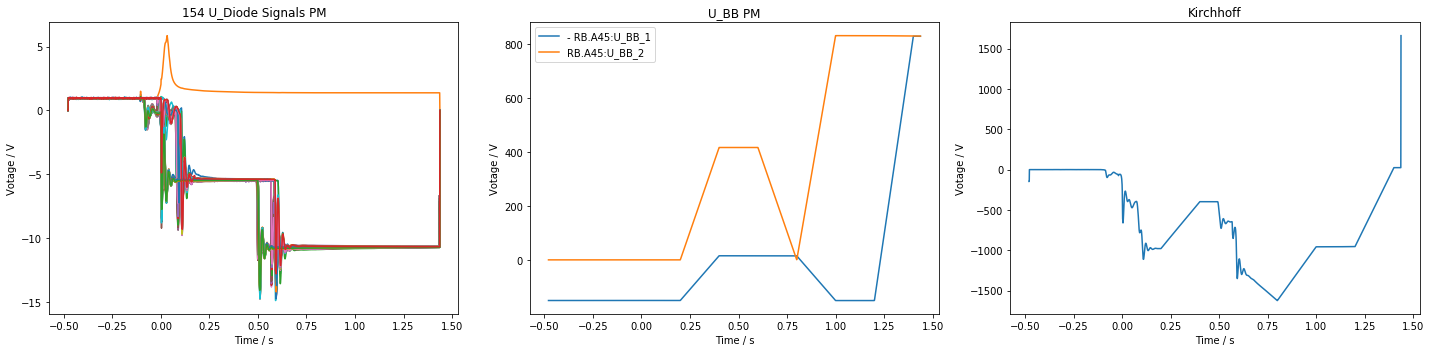

In [8]:
# plot signals
fig, ax = plt.subplots(1,3, figsize=(20,5))
df_udiode_pm.plot(ax=ax[0], legend=False, title=f"{len(df_udiode_pm.columns)} U_Diode Signals PM", xlabel='Time / s' , ylabel='Votage / V')

df_sum_pm[['- '+df_ubb1_pm.columns.values[0],df_ubb2_pm.columns.values[0]]].plot(ax=ax[1], title='U_BB PM', xlabel='Time / s' , ylabel='Votage / V')

df_sum_pm.sum(axis=1).plot(ax=ax[2], legend=False, title='Kirchhoff', xlabel='Time / s' , ylabel='Votage / V')

plt.tight_layout()
plt.show()

# NXCALS Signals

In [9]:
from lhcsmapi.api import query

circuit_name = 'RB.A45'
duration = 49_800_000_000

df_ubb1_nxcals = query.query_cmw_by_variables(spark, fgc_timestamp, duration, f'{circuit_name}:U_BB_1') 
df_ubb2_nxcals = query.query_cmw_by_variables(spark, fgc_timestamp, duration, f'{circuit_name}:U_BB_2') 

In [10]:
list_udiode_nxcals = VoltageNXCALS(**fpa_identifier, spark=spark).get_signal_data()
df_udiode_nxcals = u_diode_data_to_df(list_udiode_nxcals, len_data=len(list_udiode_nxcals[0]))

	Querying NXCALS signal(s) MB.A8R4:U_DIODE_RB, MB.B8R4:U_DIODE_RB, MB.A9R4:U_DIODE_RB, MB.B9R4:U_DIODE_RB, MB.A10R4:U_DIODE_RB... from 2021-05-04 08:26:10.660 to 2021-05-04 08:35:20.660
	Querying NXCALS signal(s) MB.A8R4:U_EARTH_RB, MB.B8R4:U_EARTH_RB, MB.A11R4:U_EARTH_RB, MB.B10R4:U_EARTH_RB, MB.B13R4:U_EARTH_RB... from 2021-05-04 08:26:10.660 to 2021-05-04 08:35:20.660


In [11]:
df_sum_nxcals = df_ubb2_pm.copy()
df_sum_nxcals['- ' + df_ubb1_pm.columns.values[0]] = -interp(df_ubb1_pm, df_ubb2_pm.index) 
df_sum_nxcals[df_udiode_nxcals.filter(regex='DIODE').columns] = interp(df_udiode_nxcals.filter(regex='DIODE'), df_ubb2_pm.index) 

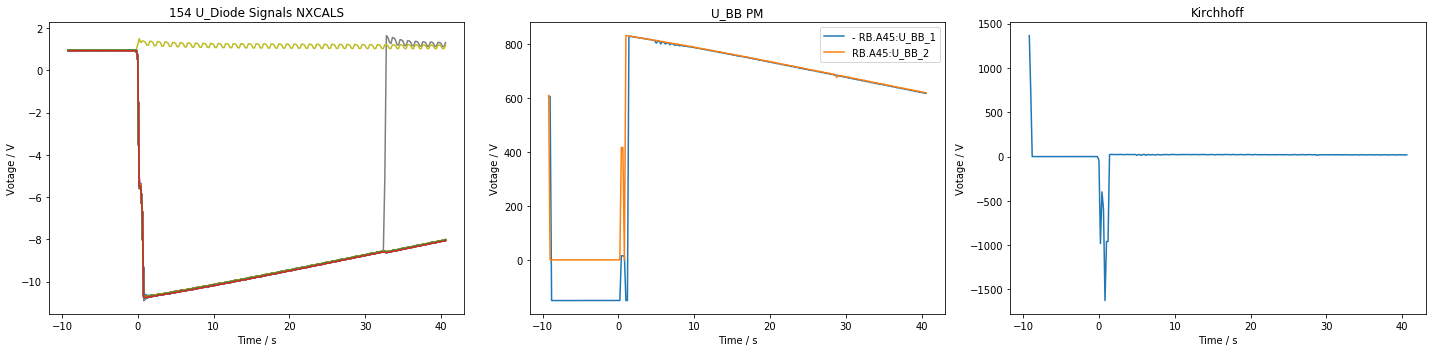

In [12]:
# plot signals
fig, ax = plt.subplots(1,3, figsize=(20,5))
df_sum_nxcals.filter(regex='DIODE').plot(ax=ax[0], legend=False, title=f"{len(df_sum_nxcals.filter(regex='DIODE').columns)} U_Diode Signals NXCALS", xlabel='Time / s' , ylabel='Votage / V')

df_sum_nxcals[['- '+df_ubb1_pm.columns.values[0],df_ubb2_pm.columns.values[0]]].plot(ax=ax[1], title='U_BB PM', xlabel='Time / s' , ylabel='Votage / V')

df_sum_nxcals.sum(axis=1).plot(ax=ax[2], legend=False, title='Kirchhoff', xlabel='Time / s' , ylabel='Votage / V')

plt.tight_layout()
plt.show()